# VAE bac à sable v2

source : https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

faire une courbe en augmrntant la diference sur ce pixel en fonction de lq KL divergence
+ evolution des images en fonction de l'évolution de l'espace latent
+ (contraire de pt1) évolution de l'espace latent en fonction de l'image d'entrée (faire varier l'image d'entrée pour regarder l'évolution du latent space)
  + faire une courbe de différence pour les points 1 et 2

In [29]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import os
from PIL import Image
import pandas as pd
import cv2
from sklearn.preprocessing import scale, minmax_scale
from sklearn.metrics import mean_squared_error

import random
from typing import Callable

# Importation des données et mise en forme

In [30]:
data = pd.read_csv("canard2.csv", header=None, index_col=None)
data

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,217.0,176.0,...,235.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,239.0,216.0,...,243.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,226.0,181.0,...,233.0,252.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,226.0,181.0,...,243.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,235.0,214.0,...,244.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,239.0,221.0,...,244.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4996,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,191.0,121.0,...,208.0,252.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4997,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,239.0,216.0,...,243.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4998,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,226.0,181.0,...,243.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [31]:
dims = (28, 28)

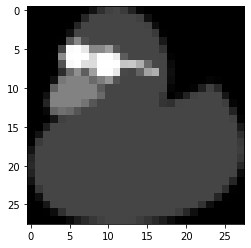

In [32]:
plt.imshow(np.array(data.iloc[1, :]).reshape(dims), cmap="Greys")

In [33]:
class CustomDataSet(Dataset):
    def __init__(self, csv_data, transform=None):
        self.df = csv_data
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        line = self.df.iloc[index, :]
        line = torch.tensor(minmax_scale(line), dtype=torch.float32)
        if self.transform:
            line = self.transform(line)
        return line

In [34]:
dataset_cat = CustomDataSet(data)
batch_size = 64
data_loader = DataLoader(dataset=dataset_cat, batch_size=batch_size, shuffle=True)

In [35]:
device = "cpu"

In [36]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) ##espace latent
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

AE excels at learning compact data representations, but the latent space is not regularized, meaning it lacks specific constraints on the distribution of points in space Z. Consequently, while proficient in compression and reconstruction, AE cannot effectively generate new data.

The key difference between a standard autoencoder and a VAE lies in the way the latent space is represented. While a standard autoencoder outputs a single point in the latent space, a VAE's encoder network outputs two sets of parameters - the mean (μ) and the standard deviation (σ) of a Gaussian distribution in the latent space. This allows the VAE to express not just a single point, but a distribution of potential representations. The VAE architecture consists of two main components: the encoder network, which transforms the input data into a probability distribution in the latent space, and the decoder network, which takes a sample from the latent distribution and reconstructs the original input. The VAE loss function is composed of two terms: the reconstruction loss, which measures how well the VAE can reconstruct the input data, and the Kullback-Leibler (KL) divergence loss, which encourages the learned latent distribution to match a target distribution, typically a standard normal distribution. This architecture enables the VAE to learn a continuous, probabilistic latent representation of the input data, which can be useful for tasks like sampling and interpolation in the latent space.

Insere schema

In [37]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

The loss function of a VAE is composed of two main components: the reconstruction loss and the Kullback-Leibler (KL) divergence loss. 
- The reconstruction loss measures how well the VAE can reconstruct the input data, typically calculated using a metric like Binary Cross-Entropy (BCE) loss between the original input and the reconstructed output. This encourages the VAE to learn an efficient encoding of the input data. 
- The KL divergence loss, on the other hand, measures the difference between the distribution learned by the VAE encoder (the approximate posterior distribution q(z|x)) and a target distribution, usually a standard normal distribution p(z). This KL divergence loss encourages the learned latent distribution to match the target distribution, which is important for enabling useful properties like sampling and interpolation in the latent space. The total loss function for training a VAE is the sum of these two components, with the reconstruction loss and KL divergence loss balanced by a scaling factor that can be tuned based on the specific problem and dataset.

  ## inserer image avec l'espace latent proche

In [38]:
def train(model, optimizer, epochs, device, data=data_loader, x_dim=784, expect_label=True):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(data):
            if expect_label:
                x, y = x
            x = x.view(x.size(), x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [39]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Indice 0 de l'espace latent")
    plt.ylabel("Indice 1 de l'espace latent")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [40]:
vae_canard = VAE(28*28, hidden_dim=500, latent_dim=100)

In [41]:
optimizer = optim.Adam(vae_canard.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
train(vae_canard, optimizer, 120, device, data=data_loader, x_dim=40*40, expect_label=False)
# vae_canard.load_state_dict(torch.load("model", map_location=device))

	Epoch 1 	Average Loss:  461.9099301069211
	Epoch 2 	Average Loss:  373.4871696080917
	Epoch 3 	Average Loss:  355.29774083846655
	Epoch 4 	Average Loss:  335.6850976699438
	Epoch 5 	Average Loss:  330.9937060918563
	Epoch 6 	Average Loss:  327.1270478077424
	Epoch 7 	Average Loss:  324.1586448473808
	Epoch 8 	Average Loss:  321.92875172541693
	Epoch 9 	Average Loss:  320.31633181449695
	Epoch 10 	Average Loss:  319.12632682995917
	Epoch 11 	Average Loss:  318.0442075484838
	Epoch 12 	Average Loss:  317.01029777526855
	Epoch 13 	Average Loss:  316.0693538861397
	Epoch 14 	Average Loss:  315.47291530706946
	Epoch 15 	Average Loss:  315.01377829527246
	Epoch 16 	Average Loss:  314.6638167454646
	Epoch 17 	Average Loss:  314.36461086762256
	Epoch 18 	Average Loss:  314.2267140119504
	Epoch 19 	Average Loss:  313.9362389002091
	Epoch 20 	Average Loss:  313.81042632078515
	Epoch 21 	Average Loss:  313.67386646759815
	Epoch 22 	Average Loss:  313.47944083580603
	Epoch 23 	Average Loss:  313.

1537746.5920410156

In [43]:
# PATH = "model"
# torch.save(vae_canard.state_dict(), PATH)

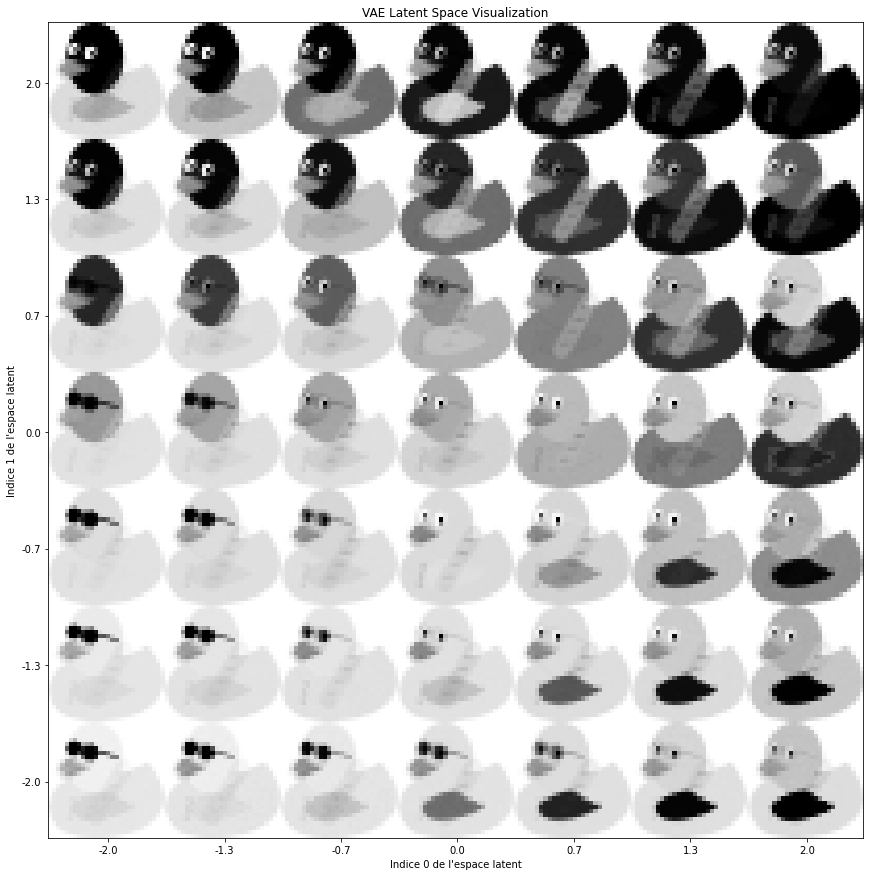

In [44]:
plot_latent_space(vae_canard, n=7, digit_size=dims[0], figsize=15, scale=2)

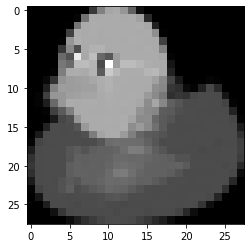

In [45]:
plt.imshow(vae_canard(torch.zeros(28*28))[0].detach().numpy().reshape(dims), cmap="Greys")

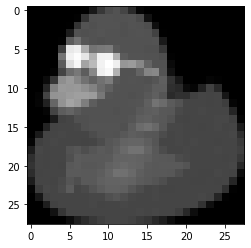

In [46]:
jsp = torch.zeros(28*28)
jsp[1] = 1
plt.imshow(vae_canard(jsp)[0].detach().numpy().reshape(dims), cmap="Greys")

In [47]:
vae_canard(jsp)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9958, 0.9221,
         0.8261, 0.7761, 0.7684, 0.7942, 0.8665, 0.9757, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9907, 0.8401,
         0.7705, 0.7692, 0.7683, 0.7682, 0.7697, 0.7643, 0.7830, 0.9393, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9957, 0.8414,
         0.7672, 0.7672, 0.7667, 0.7701, 0.7702, 0.7703, 0.7709, 0.7680, 0.7768,
         0.9519, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9136,
         0.7696, 0.7695, 0.7658, 0.7644, 0.7688, 0.7723, 0.7710, 0.7658, 0.7677,
         0.7658, 0.8005, 0.9945, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

## Débruitage

In [48]:
## ajouter du bruit sur les ducks
### faire un dataset avec les images bruitées
## afficher les images debruite
### utiliser un classifieur mais pour les canard je ne sais pas comme faire
def noisy(noise_typ: str, data_frame: np.array, intensity: float=0.1):
    def add_gaussian_noise(row, intensity):
        mean=0
        var=intensity
        sigma=var/2**.5
        noise=np.random.normal(mean,sigma,len(row))
        return row+noise

    def add_salt_and_pepper_noise(row, intensity):
        s_vs_p = 0.5
        amount = intensity
        out = row.copy()
        # Salt mode
        num_salt = np.ceil(amount * len(row) * s_vs_p)
        salt_coords = np.random.randint(0, len(row) - 1, int(num_salt))
        out[salt_coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * len(row) * (1. - s_vs_p))
        pepper_coords = np.random.randint(0, len(row) - 1, int(num_pepper))
        out[pepper_coords] = 0

        return out

    def add_speckle_noise(row, intensity):
        gauss = np.random.randn(len(row))
        return row + row * gauss * intensity

    match noise_typ:
        case "gauss":
            return np.apply_along_axis(lambda row: add_gaussian_noise(row, intensity), axis=1, arr=data_frame)

        case "s&p":
            return np.apply_along_axis(lambda row: add_salt_and_pepper_noise(row, intensity), axis=1, arr=data_frame)

        case "speckle":
            return np.apply_along_axis(lambda row: add_speckle_noise(row, intensity), axis=1, arr=data_frame)

        case _:
            raise ValueError("Unsupported noise type. Choose from 'gauss', 's&p', or 'speckle'.")

def plot_images(images, rows=5, cols=5, figsize=(10, 10)):
    """
    Plot a grid of images with their corresponding labels.

    Args:
    -----
    - images (Tensor or numpy.ndarray): Array of images.
    - labels (Tensor or numpy.ndarray): Array of labels.
    - rows (int, optional): Number of rows in the subplot grid. Default is 5.
    - cols (int, optional): Number of columns in the subplot grid. Default is 5.
    - figsize (tuple, optional): Figure size. Default is (10, 10).
    """

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0], cmap="gray")
        ax.axis('off')  # Hide axes

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

VAEs and standard AEs can be used for denoising, the VAE's probabilistic latent space and generative capabilities may provide advantages in certain denoising tasks, especially when the noise distribution is complex or unknown


In [128]:
noisy_data = noisy("gauss", data.to_numpy(), intensity=30)

In [129]:
noisy_data.shape

(5000, 784)

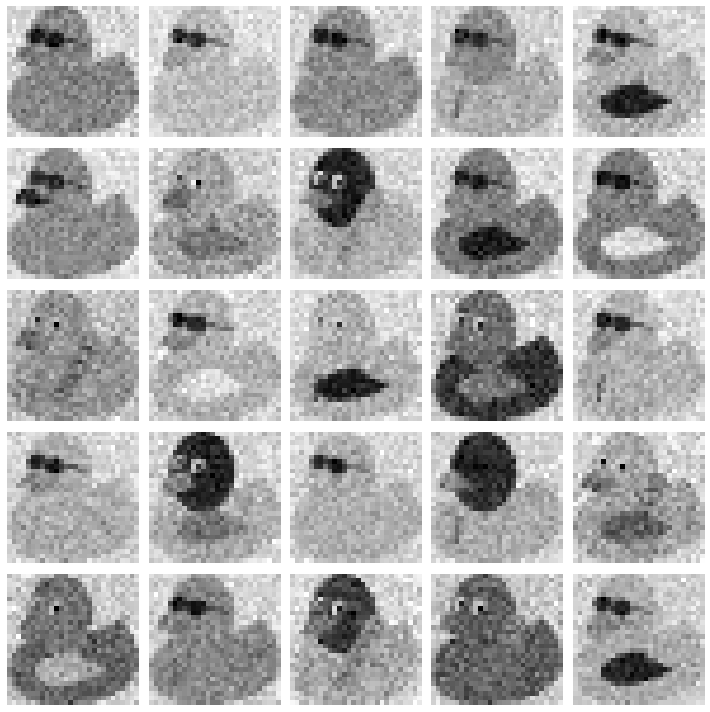

In [130]:
plot_images(minmax_scale(noisy_data, axis=1).reshape(-1,1,28,28))

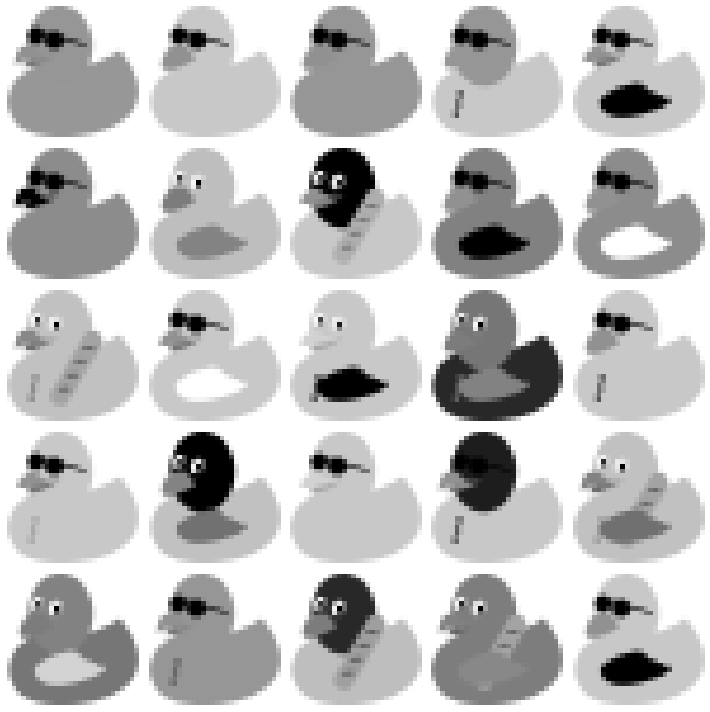

In [131]:
plot_images(minmax_scale(data.to_numpy(),axis=1).reshape(-1,1,28,28))

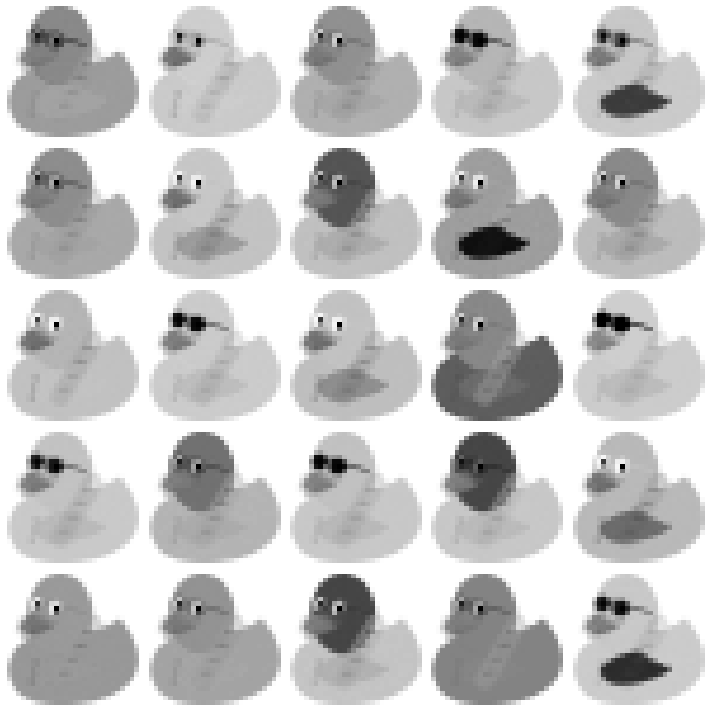

In [132]:
plot_images(vae_canard(torch.tensor(minmax_scale(noisy_data,axis=1).astype(np.float32)))[0].detach().numpy().reshape((-1,1,28,28)))

In [133]:
def measure_difference(clean, reconstruction):
    mean_img = 0
    for i in range(len(clean)):
        mean_img = mean_squared_error(clean[i], reconstruction[i])
    return mean_img/len(clean)

In [134]:
measure_difference(minmax_scale(data.to_numpy(),axis=1), minmax_scale(noisy_data, axis=1))

5.8166498561029144e-06

In [135]:
measure_difference(minmax_scale(data.to_numpy(),axis=1), vae_canard(torch.tensor(minmax_scale(noisy_data,axis=1).astype(np.float32)))[0].detach().numpy())

2.2130580633791566e-06

In [56]:
def duck_accuracy(true_duck: np.ndarray, 
                  vae_made_duck: np.ndarray, 
                  scoring: Callable) -> float:
    """
    Score function between two lists representing ducks

    Parameters:
    -----------
    true_duck: np.ndarray
        Array of the true duck (that is, without the noise added afterwards)

    vae_made_ducks: np.ndarray
        Array of the duck reconstructed by the VAE (that is, the prediction of the true_duck with noise by the VAE)
    
    scoring: Callable
        Scoring function used
    
    Returns
    -------
    score: float
        Score of the ressemblance between botch ducks
    """
    true_duck = true_duck.flatten()
    vae_made_duck = vae_made_duck.flatten()

    # check if input is normalised (we assume that the output of the VAE is normalised)
    if np.max(true_duck) > np.max(vae_made_duck):
        true_duck = minmax_scale(true_duck)

    return scoring(true_duck, vae_made_duck)


In [57]:
duck_accuracy(data.iloc[4, :].to_numpy(), 
              vae_canard(torch.tensor(noisy_data[4]).type(torch.float32))[0].detach().numpy(), 
              mean_squared_error)

0.08825503153062374

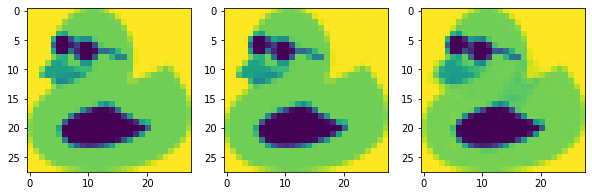

In [58]:
f, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].imshow(data.iloc[4, :].to_numpy().reshape((28, 28)))
ax[1].imshow(noisy_data[4].reshape((28, 28)))
ax[2].imshow(vae_canard(torch.tensor(minmax_scale(noisy_data[4])).type(torch.float32))[0].detach().numpy().reshape((28, 28)))

In [59]:
error = 0
for i in range(len(data)):
    error += duck_accuracy(data.iloc[i, :].to_numpy(), 
                           vae_canard(torch.tensor(noisy_data[i]).type(torch.float32))[0].detach().numpy(), 
                           mean_squared_error)
error/len(data)

0.11694328592468581

Le salt'n'pepper est assez violent, mais le VAE peut quand même reconstruire avec 11% d'erreur <span style="color:red"> je suis pas sûr avec le pourcentage par contre

### Test avec le speckle

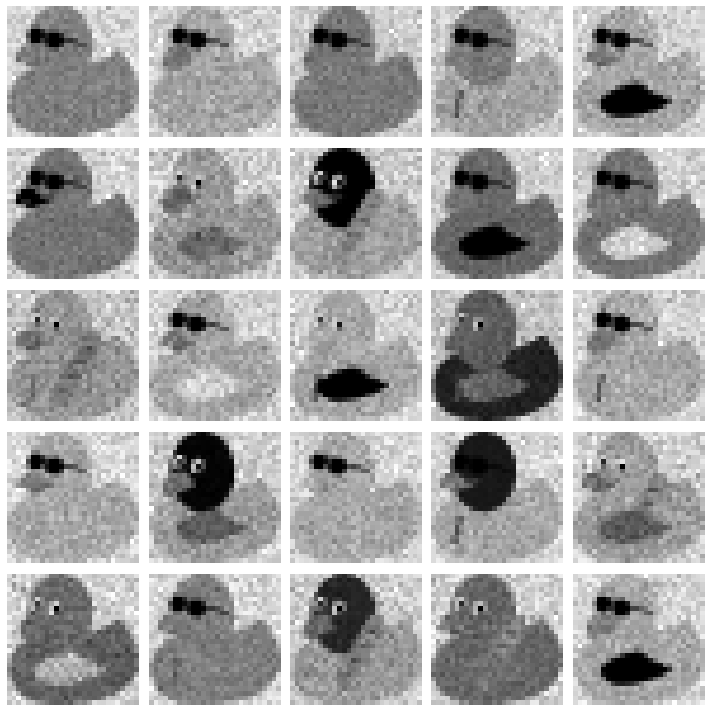

In [60]:
noisy_data = noisy("speckle", data.to_numpy(), intensity=0.08)
plot_images(minmax_scale(noisy_data, axis=1).reshape(-1,1,28,28))

In [61]:
error = 0
for i in range(len(data)):
    error += duck_accuracy(data.iloc[i, :].to_numpy(), 
                           vae_canard(torch.tensor(noisy_data[i]).type(torch.float32))[0].detach().numpy(), 
                           mean_squared_error)
error/len(data)

0.11708677840243926

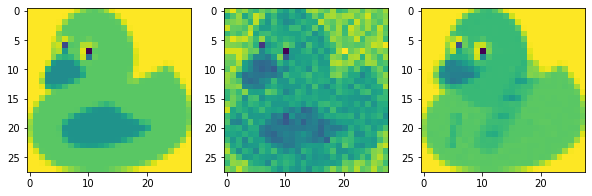

In [62]:
f, ax = plt.subplots(1, 3, figsize=(10, 10))

choosen_duck = 6
ax[0].imshow(data.iloc[choosen_duck, :].to_numpy().reshape((28, 28)))
ax[1].imshow(noisy_data[choosen_duck].reshape((28, 28)))
ax[2].imshow(vae_canard(torch.tensor(minmax_scale(noisy_data[choosen_duck])).type(torch.float32))[0].detach().numpy().reshape((28, 28)))

In [63]:
duck_accuracy(data.iloc[3, :].to_numpy(), 
              vae_canard(torch.tensor(np.zeros(784)).type(torch.float32))[0].detach().numpy(), 
              mean_squared_error)

0.007280056169846981

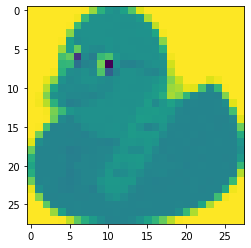

In [64]:
plt.imshow(vae_canard(torch.tensor(np.zeros(784)).type(torch.float32))[0].detach().numpy().reshape((28, 28)))

---

In [65]:
canard_rapport = pd.read_csv("dataset_rapport/canard_rapport.csv", header=None, index_col=0).T.apply(minmax_scale)

In [66]:
canard_rapport

,ww,baguette,wing,normal,lunette
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
780,1.0,1.0,1.0,1.0,1.0
781,1.0,1.0,1.0,1.0,1.0
782,1.0,1.0,1.0,1.0,1.0
783,1.0,1.0,1.0,1.0,1.0


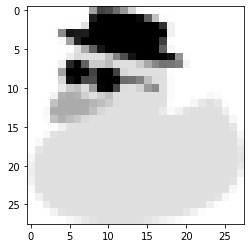

In [67]:
plt.imshow(1 - canard_rapport["ww"].to_numpy().reshape((28, 28)), cmap="Greys")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


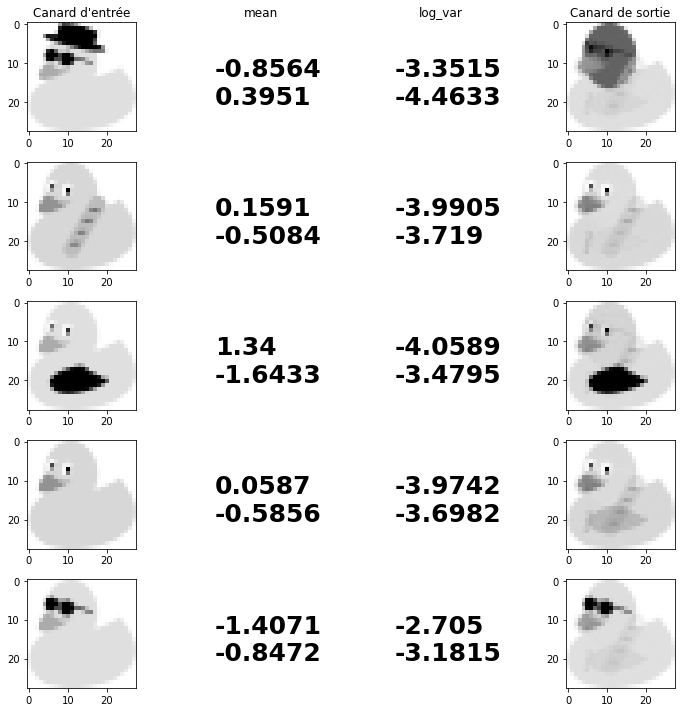

In [68]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}

f, axes = plt.subplots(len(canard_rapport.columns), 4, figsize=(10, 10))
axes[0, 0].set_title("Canard d'entrée")
axes[0, 1].set_title("mean")
axes[0, 2].set_title("log_var")
axes[0, 3].set_title("Canard de sortie")

for i, col in enumerate(canard_rapport.columns):
    prediction, mean, log_var = vae_canard(torch.tensor(canard_rapport[col].to_numpy(), dtype=torch.float32))
    prediction = prediction.detach().view((28, 28))
    mean = "\n".join([str(round(i.item(), 4)) for i in mean])
    log_var = "\n".join([str(round(i.item(), 4)) for i in log_var])

    axes[i, 0].imshow(1 - canard_rapport[col].to_numpy().reshape((28, 28)), cmap="Greys")
    axes[i, 1].text(0.2, 0.25, mean, font)
    axes[i, 1].axis("off")
    axes[i, 2].text(0.2, 0.25, log_var, font)
    axes[i, 2].axis("off")
    axes[i, 3].imshow(1 -prediction, cmap="Greys")
plt.tight_layout()

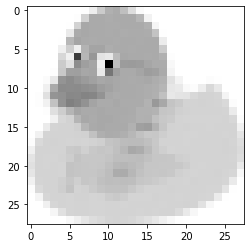

In [69]:
plt.imshow(1 - vae_canard.decoder(torch.tensor([[0.0, 0.0]])).detach().numpy().reshape((28, 28)), cmap="Greys")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 2x100)

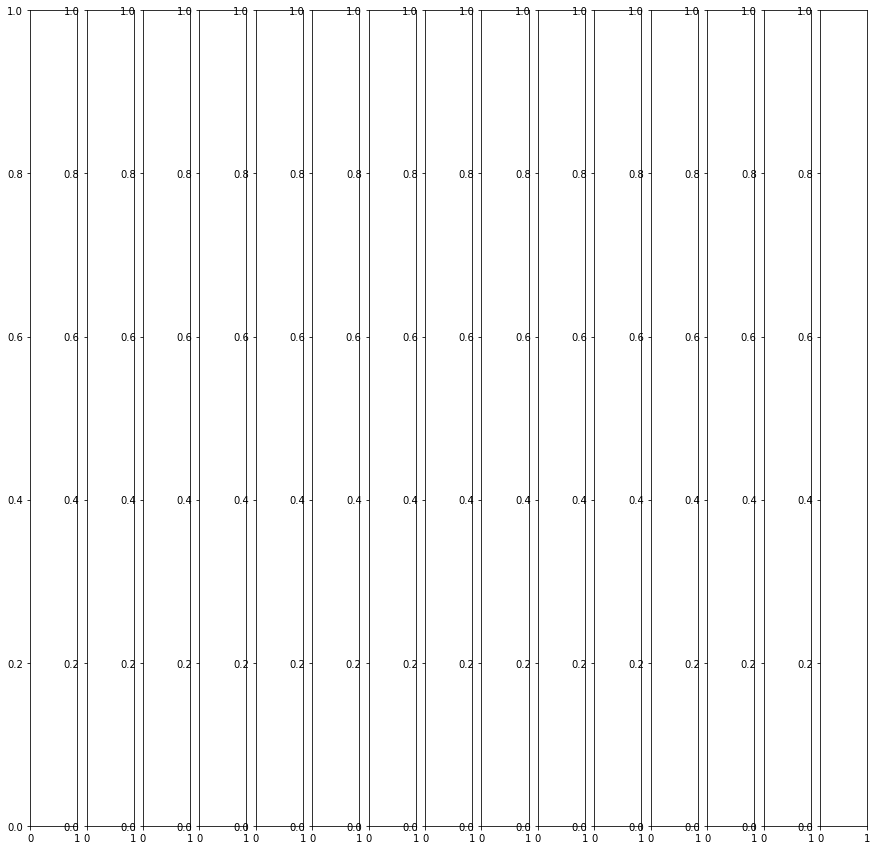

In [70]:
fig, axes = plt.subplots(1, 15, figsize=(15, 15))
a = torch.zeros(1, 10)
for i, ax in enumerate(axes.flat):
    a[0][9] = i-4
    ax.imshow(vae_canard.decoder(a).detach().numpy().reshape((28, 28)), cmap="gray")
    ax.set_title(f"{[i-4, 0.0]}")
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 2x100)

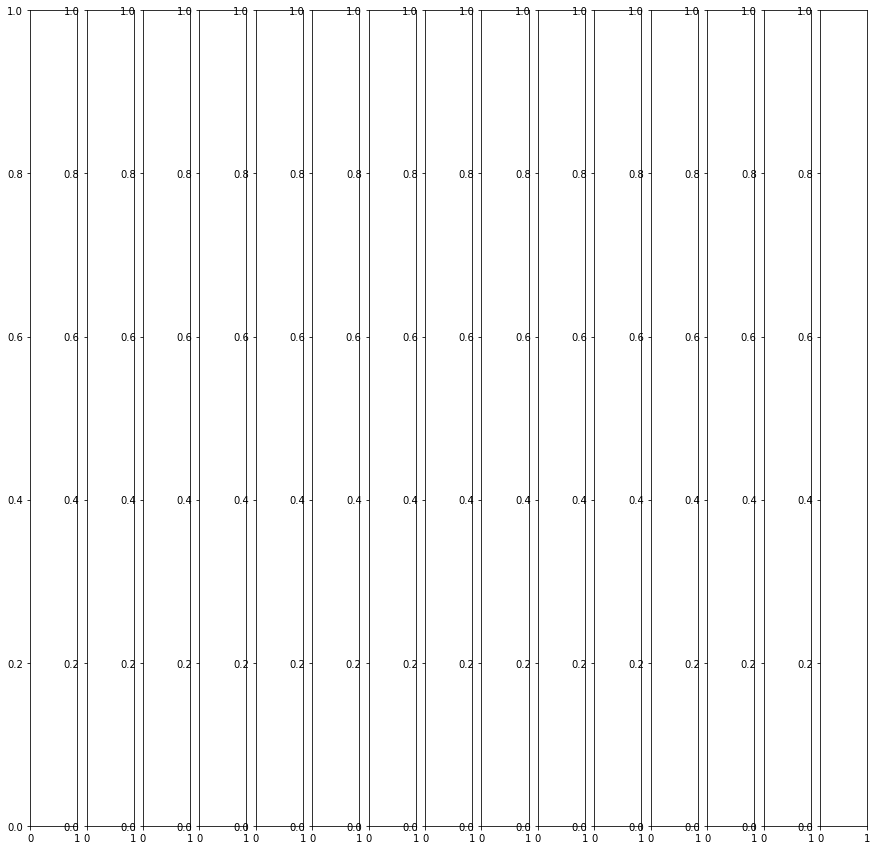

In [ ]:
fig, axes = plt.subplots(1, 15, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(vae_canard.decoder(torch.tensor([[0.0, i-4, 0.0, 0.0, 0.0]])).detach().numpy().reshape((28, 28)), cmap="gray")
    ax.set_title(f"{[0.0, i-4]}")
    ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing between subplots
plt.show()